In [3]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score
warnings.simplefilter('ignore')
sns.set()
%matplotlib inline
from fancyimpute import KNN
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
import json
import os
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import time

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
import lightgbm as lgb

In [4]:
# Read Files
X_train = pd.read_csv('../data/output/resampled_rf_imputed_X_train.csv', index_col=0)
X_test = pd.read_csv('../data/output/rf_imputed_X_test.csv', index_col = 0)

y_train = pd.read_csv('../data/output/resampled_y_train.csv')['isFraud']
y_test = pd.read_csv('../data/output/y_test.csv')['isFraud']

In [5]:
X_train.shape, y_train.shape

((458224, 308), (458224,))

In [6]:
X_test.shape, y_test.shape

((118108, 308), (118108,))

## Feature Selection

#### Time Consistency

So we currently have 258 features now. We will now check each of our 258 features for "time consistency". We will build 258 models. Each model will be trained on the first month of the training data and will only use one feature. We will then predict the last month of the training data. We want both training AUC and validation AUC to be above AUC = 0.5. It turns out that 19 features fail this test so we will remove them. Additionally we will remove 7 D columns that are mostly NAN. 

In [7]:
cols = list( X_train.columns )
# cols.remove('TransactionDT')
for c in ['D6','D7','D8','D9','D12','D13','D14']:
    if c in cols:
        cols.remove(c)
for c in ['oof','DT_M','day','uid']:
    if c in cols:
        cols.remove(c)
# FAILED TIME CONSISTENCY TEST
for c in ['C3','M5','id_08','id_33']:
    if c in cols:
        cols.remove(c)
for c in ['card4','id_07','id_14','id_21','id_30','id_32','id_34']:
    if c in cols:
        cols.remove(c)
for c in ['id_'+str(x) for x in range(22,28)]:
    if c in cols:
        cols.remove(c)

In [8]:
X_train = X_train[cols]
X_test = X_test[cols]

In [9]:
X_train.shape, X_test.shape

((458224, 291), (118108, 291))

#### RFECV

In [10]:
percent = 25 # percent of dataset to use for feature selection

x_train_train, x_train_valid, y_train_train, y_train_valid = train_test_split(X_train, y_train, test_size=1.0-percent/100.0, random_state=42)

In [11]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': False,
    'boost_from_average': True,
    'num_threads': 4,
    
    'num_leaves': 500,
    # 'min_data_in_leaf': 25,
    'max_depth': -1,
    'learning_rate': 0.01
}

# n_jobs=-1 causes out of memory
feature_selector = RFECV(lgb.LGBMClassifier(**params), step=10, scoring='roc_auc', cv=5, verbose=1)
feature_selector.fit(x_train_train, y_train_train)
print('Features selected:', feature_selector.n_features_)


Fitting estimator with 291 features.
[LightGBM] [Info] Number of positive: 25787, number of negative: 65857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62279
[LightGBM] [Info] Number of data points in the train set: 91644, number of used features: 290
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.281382 -> initscore=-0.937615
[LightGBM] [Info] Start training from score -0.937615
Fitting estimator with 281 features.
[LightGBM] [Info] Number of positive: 25787, number of negative: 65857
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 62002
[LightGBM] [Info] Number of data p

In [12]:
selected_features = [f for f in x_train_train.columns[feature_selector.ranking_ == 1]]

selected_features

['TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D10',
 'D11',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M6',
 'M7',
 'M8',
 'V3',
 'V4',
 'V6',
 'V8',
 'V11',
 'V13',
 'V17',
 'V20',
 'V23',
 'V26',
 'V30',
 'V36',
 'V37',
 'V40',
 'V41',
 'V44',
 'V47',
 'V48',
 'V54',
 'V56',
 'V59',
 'V62',
 'V67',
 'V70',
 'V76',
 'V78',
 'V80',
 'V82',
 'V86',
 'V88',
 'V91',
 'V115',
 'V123',
 'V124',
 'V127',
 'V129',
 'V130',
 'V136',
 'V138',
 'V139',
 'V142',
 'V147',
 'V156',
 'V160',
 'V162',
 'V165',
 'V166',
 'V169',
 'V171',
 'V173',
 'V175',
 'V176',
 'V178',
 'V180',
 'V187',
 'V188',
 'V198',
 'V203',
 'V205',
 'V207',
 'V209',
 'V210',
 'V218',
 'V220',
 'V221',
 'V223',
 'V224',
 'V226',
 'V228',
 'V229',
 'V234',
 'V238',
 'V240',
 'V250',
 'V253',
 'V257'

# Compare score (all features vs selected features)

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
percent = 25 # percent of dataset to use for validation

_, x_train_valid_part, _, y_train_valid_part = train_test_split(x_train_valid, y_train_valid, test_size=percent/100.0, random_state=42)

In [15]:
lgb_model = lgb.LGBMClassifier(**params).fit(x_train_train, y_train_train)
y_all_features = lgb_model.predict_proba(x_train_valid_part)[:,1]
score_all_features = roc_auc_score(y_train_valid_part, y_all_features)
print('Score / all features:', score_all_features)

[LightGBM] [Info] Number of positive: 32234, number of negative: 82322
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110887 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62342
[LightGBM] [Info] Number of data points in the train set: 114556, number of used features: 290
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.281382 -> initscore=-0.937617
[LightGBM] [Info] Start training from score -0.937617
Score / all features: 0.9856292864221717


In [16]:
y_selected_features = feature_selector.estimator_.predict_proba(x_train_valid_part[selected_features])[:,1]
score_selected_features = roc_auc_score(y_train_valid_part, y_selected_features)
print('Score / selected features:', score_selected_features)

Score / selected features: 0.9856849967260755


In [17]:
print('Score change:', score_selected_features-score_all_features)

Score change: 5.5710303903722114e-05


In [18]:
feature_importance_df = pd.concat([
    pd.Series(x_train_train.columns),
    pd.Series(lgb_model.feature_importances_)], axis=1)
feature_importance_df.columns = ['featureName', 'importance']

feature_importance_df['selected'] = feature_importance_df['featureName'].map(lambda x: x in selected_features)

In [19]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(feature_importance_df.sort_values(by=['importance'], ascending=False))

                                       featureName  importance  selected
283                                     uid_C13_ct        1009      True
12                                              C1         944      True
150                                           V294         807      True
192                                    card1_addr1         787      True
284                                    uid_V314_ct         750      True
191                               P_emaildomain_FE         691      True
193                      card1_addr1_P_emaildomain         603      True
287                                    uid_V309_ct         602      True
24                                             C14         575      True
266                                   C13_uid_mean         522      True
197                       TransactionAmt_card1_std         519      True
6                                            card6         509      True
245                        TransactionAmt_uid_mean 

In [20]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.99574282 0.00425718]
 [0.12013754 0.87986246]]


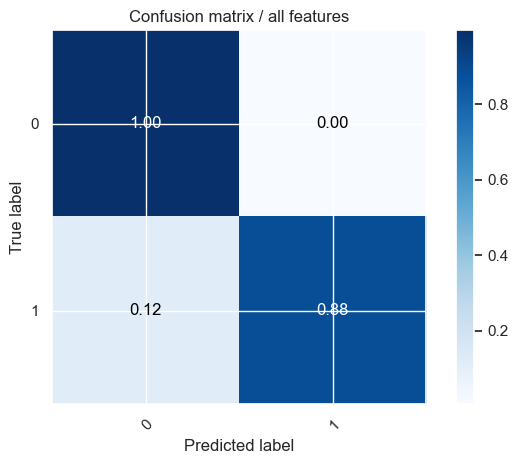

In [21]:
classes = pd.Series([0,1])

plot_confusion_matrix(y_train_valid_part, y_all_features.round(), classes=classes, normalize=True,
                      title='Confusion matrix / all features')

plt.show()

Normalized confusion matrix
[[0.9956457  0.0043543 ]
 [0.11988898 0.88011102]]


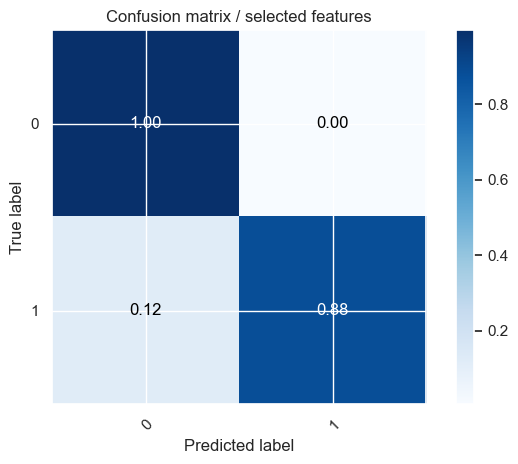

In [22]:
plot_confusion_matrix(y_train_valid_part, y_selected_features.round(), classes=classes, normalize=True,
                      title='Confusion matrix / selected features')

plt.show()

### ROC Curve

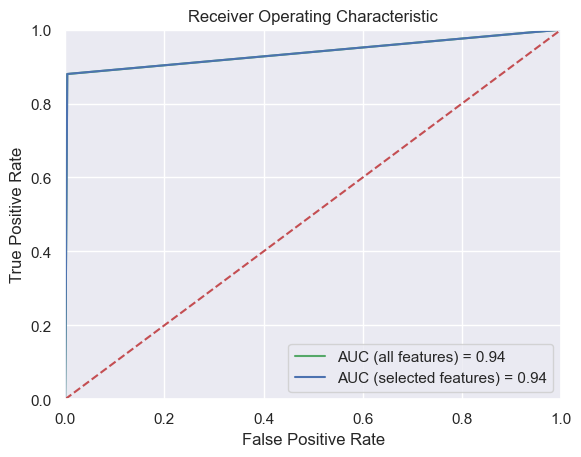

In [23]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr_all_features, tpr_all_features, _ = roc_curve(y_train_valid_part, y_all_features.round())
roc_auc_all_features = auc(fpr_all_features, tpr_all_features)

fpr_selected_features, tpr_selected_features, _ = roc_curve(y_train_valid_part, y_selected_features.round())
roc_auc_selected_features = auc(fpr_selected_features, tpr_selected_features)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_all_features, tpr_all_features, 'g', label = 'AUC (all features) = %0.2f' % roc_auc_all_features)
plt.plot(fpr_selected_features, tpr_selected_features, 'b', label = 'AUC (selected features) = %0.2f' % roc_auc_selected_features)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [24]:
final_X_train = X_train[selected_features] 
final_X_test = X_test[selected_features]

In [25]:
final_X_train.to_csv('../data/output/final_X_train.csv')
final_X_test.to_csv('../data/output/final_X_test.csv')